# Data Visualization: Rules and Guidelines
`Version: 2020-11-11`

> **Co-author**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)


**Prerequisites**

- [Introduction to Plotting](../scientific/plotting.ipynb)  


**Outcomes**

- Understand steps of creating a visualization  
- Know when to use each of the core plots  
- Introductory ability to make effective visualizations  

## Outline

- [Data Visualization: Rules and Guidelines](#Data-Visualization:-Rules-and-Guidelines)  
  - [Introduction](#Introduction)  
  - [Steps to Creating Effective Charts](#Steps-to-Creating-Effective-Charts)  
  - [Visualization Types](#Visualization-Types)  
  - [Color in Plots](#Color-in-Plots)  
  - [Visualization Rules](#Visualization-Rules)  
  - [References](#References)  
  - [Exercises](#Exercises)  

In [2]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [1]:
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm

from pandas_datareader import DataReader

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();
from pandas.util.testing import assert_frame_equal

C:\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Introduction

An economist’s (or data scientist’s) job goes beyond simply learning new things using data and
theory.

Learning these new things is meant to help economists or data scientists communicate these ideas to others,
whether the medium is an academic paper or a business meeting.

One of the most effective mediums of communication is visualization.

Well-done visualizations can help your audience remember your message.

They accomplish this through at least two main channels:

>1. Psychology researchers have observed [*picture superiority*](https://en.wikipedia.org/wiki/Picture_superiority_effect): the fact that images are more likely to be remembered than
words. While the reasons and extent of the effect are debated, the consensus view is that the effect exists.
How large might this effect be? In a paper by Defeyter, Russo, and McPartlin (2009), the authors found that participants were able to identify pictures they had previously studied for approximately 500 ms each with 75-85% accuracy but words with only a 55-65% accuracy.

>2. Data visualizations help people walk through the logic you used to build the chart,
  allowing them to reason through the argument and thus makes your claim more convincing.  


In this lecture, we will discuss the process of creating a data visualization, ways to best ensure
successfully communication, and some general design guidelines.

Along the way, you will be introduced to many features of `matplotlib` that were not discussed in the
introductory lecture.

We won’t discuss most of these features, but we encourage you to read more in the
[online documentation](https://matplotlib.org/contents.html) if you have questions.

## Steps to Creating Effective Charts

Before we begin discussions of specific recommendations, it is helpful to agree on
the goal of a data visualization and a process that can be used to accomplish the goal.

As mentioned in the introduction, the purpose of a visualization is to facilitate the communication
of a message or idea.

We have found the following steps to be useful for achieving this goal:

1. Identify the message.  
1. Describe your visualization.  
1. Create a draft of the visualization (and verify your data!).  
1. Fine tune the visualization details.  


After discussing the role research plays in data visualization, we will use an example to provide
deeper context for the remaining steps.

**Step 0: Research**

Before we proceed, note that prior to reaching this process, you will have spent
a significant amount of time exploring the data and thinking about your overall message.

In fact, during the research step, you will almost certainly produce visualizations to help yourself
understand the data.

These visualizations can highlight outliers or unlikely combinations of variables.

For example, NYC publishes data on taxi pickups and dropoffs.

One might expect tips to be somewhat independent of whether someone pays cash or credit, but
the 75th percentile tip for cash payers is 0!

Because it’s unlikely that cash payers choose not to tip, one likely explanation
is a reporting issue in the data collection.

The steps and guidelines that follow may be helpful in the research process, but refining each of your exploratory visualizations to a publishable version is not practical.
Some of these recommendations will be specific to creating a visualization after you understand the story you’re telling.

### Example

The output of this example will be a reproduction of a visualization from
[this NYT article](https://www.nytimes.com/2019/01/11/upshot/big-cities-low-skilled-workers-wages.html).

This NYT article is based on research done by David Autor <sup>[1](#ely)</sup> , an
economist at MIT, and his co-authors.

Autor’s research investigates __the observable changes over time between work opportunities
in rural and urban locations__ in the United States

This particular graph __explores how both college-educated workers and non-college-educated workers were 
able to find higher-paying jobs by working in urban areas__ in the 20th century.

More recently, this *city wage premium* is still apparent for those
with college educations. However, for those without a college education, it has
disappeared.

#### Identify the Message

The first step to creating a visualization might feel a little obvious, but is
the most important step.

If you fail to choose a concise message, then you won’t be able to clearly communicate the idea.

In this example, we want people to be able to answer the question, “What happened to the
rural/urban wage gap for non-college-educated workers since the 1950s?”.

Part of what makes the answer interesting is that the wage gap changes are unique to non-college-educated workers; we will want to display changes in the wage gap for college-educated workers as well.

#### Visualize

Choosing the type of visualization that best illustrates your point is an important
skill to develop.

Using the wrong type of visualization can inhibit the flow of information from the
graph to your audience’s brain.

In our case, we need to display the relationship between population density (our measure of
rural/urban) and wages for different years and education levels.

Since the wage gap will be the main focus, we want to choose a visualization that highlights
this aspect of the data.

Scatter plots are one of the most effective ways to demonstrate the relationship of two
variables.

We will place the log of population density on the x-axis and the log of wages on the y-axis.

We will then need to find a way to demonstrate this for different years and education levels.

One natural solution is to demonstrate one of these variables using color and the other using
different subplots.

In the original article, they chose to highlight differences in college
education using color and time using subplots.

#### Visualization Draft

Drafting an early version of your visualization without concerning yourself about its aesthetics allows you to think about whether it is able to answer the proposed question.

Sometimes you’ll get to this step and realize that you need to go back to one of the previous
steps…

It’s ok to scrap what you have and restart at square one.

In fact, you will frequently do this, no matter how much experience you’ve developed.

In our own work, we’ve found that it’s not uncommon to discard ten or more versions of a graph before
settling on a draft we are happy with.

Below, we create a draft of our plot.

In [2]:
# Read in data
df = pd.read_csv("https://datascience.quantecon.org/assets/data/density_wage_data.csv")
df["year"] = df.year.astype(int)  # Convert year to int


def single_scatter_plot(df, year, educ, ax, color):
    """
    This function creates a single year's and education level's
    log density to log wage plot
    """
    # Filter data to keep only the data of interest
    _df = df.query("(year == @year) & (group == @educ)")
    _df.plot(
        kind="scatter", x="density_log", y="wages_logs", ax=ax, color=color
    )

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

for (i, year) in enumerate(df.year.unique()):
    single_scatter_plot(df, year, "college", ax[i], "b")
    single_scatter_plot(df, year, "noncollege", ax[i], "r")
    ax[i].set_title(str(year))

URLError: <urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)

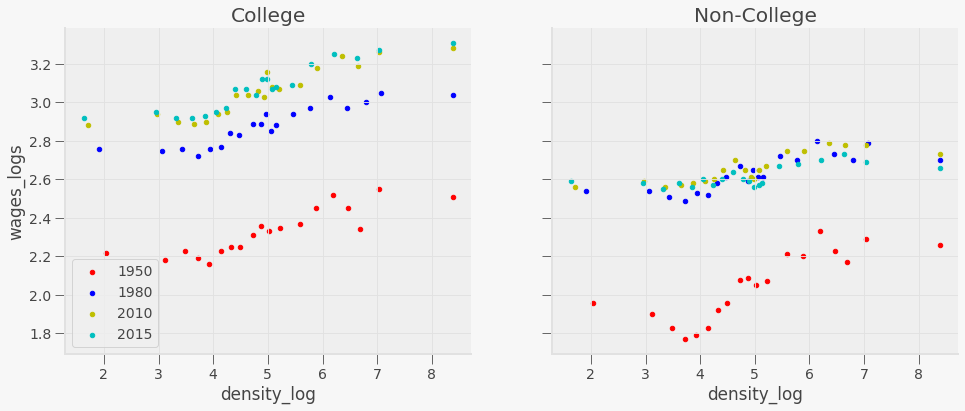

In [5]:
# Your code h
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
color = ["r", "b", "y", "c"]
for (i, year) in enumerate(df.year.unique()):
    single_scatter_plot(df, year, "college", ax[0], color[i])
    single_scatter_plot(df, year, "noncollege", ax[1], color[i])

ax[0].set_title("College")
ax[1].set_title("Non-College")
ax[0].legend(["1950", "1980", "2010" ,"2015"])

#### Fine-tune

Great! We have now confirmed that our decisions up until this point have made sense and that a
version of this graphic can successfully convey our message.

The last step is to clean the graph. We want to ensure that no features
detract or distract from our message.

Much of the remaining lecture will be dedicated to this fine-tuning, so we will post-pone
presenting the details.  However, the code we use to create the best version of this graphic is included below.

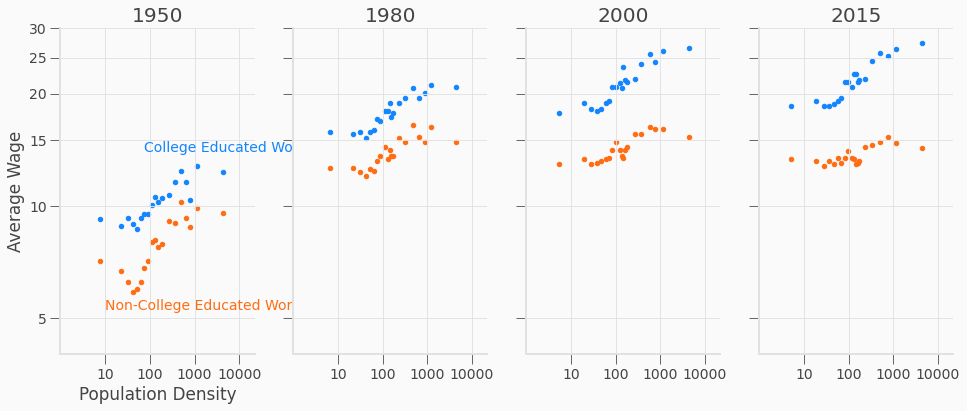

In [6]:
# Read in data
df = pd.read_csv("https://datascience.quantecon.org/assets/data/density_wage_data.csv")
df["year"] = df.year.astype(int)  # Convert year to int


def single_scatter_plot(df, year, educ, ax, color):
    """
    This function creates a single year's and education level's
    log density to log wage plot
    """
    # Filter data to keep only the data of interest
    _df = df.query("(year == @year) & (group == @educ)")
    _df.plot(
        kind="scatter", x="density_log", y="wages_logs", ax=ax, color=color
    )

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 4, figsize=(16, 6))
colors = {"college": "#1385ff", "noncollege": "#ff6d13"}

for (i, year) in enumerate(df.year.unique()):
    single_scatter_plot(df, year, "college", ax[i], colors["college"])
    single_scatter_plot(df, year, "noncollege", ax[i], colors["noncollege"])
    ax[i].set_title(str(year))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, _ax) in enumerate(ax):
    # Label with words
    if i == 0:
        _ax.set_xlabel("Population Density")
    else:
        _ax.set_xlabel("")

    # Turn off right and top axis lines
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

    # Don't use such a white background color
    _ax.set_facecolor(bgcolor)

    # Change bounds
    _ax.set_ylim((np.log(4), np.log(30)))
    _ax.set_xlim((0, 10))

    # Change ticks
    xticks = [10, 100, 1000, 10000]
    _ax.set_xticks([np.log(xi) for xi in xticks])
    _ax.set_xticklabels([str(xi) for xi in xticks])

    yticks = list(range(5, 32, 5))
    _ax.set_yticks([np.log(yi) for yi in yticks])
    if i == 0:
        _ax.set_yticklabels([str(yi) for yi in yticks])
        _ax.set_ylabel("Average Wage")
    else:
        _ax.set_yticklabels([])
        _ax.set_ylabel("")

ax[0].annotate("College Educated Workers", (np.log(75), np.log(14.0)), color=colors["college"])
ax[0].annotate("Non-College Educated Workers", (np.log(10), np.log(5.25)), color=colors["noncollege"]);

## Visualization Types

You have seen many kinds of visualizations throughout your life.

We discuss a few of the most frequently used visualization types and how they describe data below.

For a more complete list of visualization types, see the Duke library’s
[data visualization guide](https://guides.library.duke.edu/datavis/vis_types).

### Scatter Plots

Scatter plots can be used in various ways.

They are frequently used to show how two variables are related to one another or compare
various observations based on two variables.

[This article](https://qz.com/1235712/the-origins-of-the-scatter-plot-data-visualizations-greatest-invention/)
about the scatter plot is a good read.

One strength of a scatter plot is that its simplicity allows the data to speak for itself.
A plot of two variables allows viewers to immediately see whether the variables are
linearly related, quadratically related, or maybe not related at all.

We have already seen an example of a scatter plot which shows the relationship between two
variables.

Below, we demonstrate how it can be used to compare.

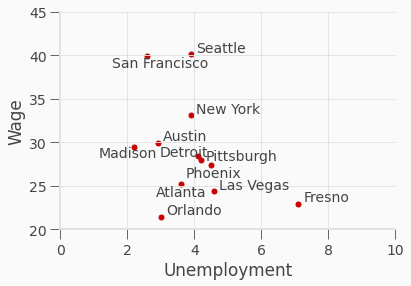

In [7]:
cities = [
    "San Francisco", "Austin", "Las Vegas", "New York", "Seattle", "Pittsburgh",
    "Detroit", "Fresno", "Phoenix", "Orlando", "Atlanta", "Madison"
]
unemp_wage = np.array([
    [2.6, 39.89], [2.9, 29.97], [4.6, 24.38], [3.9, 33.09], [3.9, 40.11], [4.2, 27.98],
    [4.1, 28.41], [7.1, 22.96], [4.5, 27.42], [3.0, 21.47], [3.6, 25.19], [2.2, 29.48]
])
df = pd.DataFrame(unemp_wage, index=cities, columns=["Unemployment", "Wage"])

fig, ax = plt.subplots()
df.plot(kind="scatter", x="Unemployment", y="Wage", ax=ax, s=25, color="#c90000")

# Add annotations
for (i, row) in df.iterrows():
    city = row.name

    if city in ["San Francisco", "Madison"]:
        offset = (-35, -10.5)
    elif city in ["Atlanta", "Phoenix", "Madison"]:
        offset = (-25, -12.5)
    elif city in ["Detroit"]:
        offset = (-38, 0)
    elif city in ["Pittsburgh"]:
        offset = (5, 0)
    else:
        offset = (5, 2.5)
    ax.annotate(
        city, xy=(row["Unemployment"], row["Wage"]),
        xytext=offset, textcoords="offset points"
    )

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
ax.set_facecolor(bgcolor)
ax.set_xlim(0, 10)
ax.set_ylim(20, 45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Line Plots

Line plots are best used to either show how a variable evolves over time or to demonstrate the
relationship between variables.

Note: it differs from scatter plots in the way it displays relationships between variables.

A line plot is restricted to displaying a line, so you cannot just draw a line between all of your
datapoints.

Instead, before drawing the line, you must fit some kind of statistical model that can
show how one variable changes as the other changes.

Below, we add regression lines which estimate the relationship between population density and wages to
our college/non-college urban wage premium plot.

In fact, Dr. Autor’s original slides contain regression lines, but the New York Times
chose to remove them.

Text(2.302585092994046, 1.6582280766035324, 'Non-College Educated Workers')

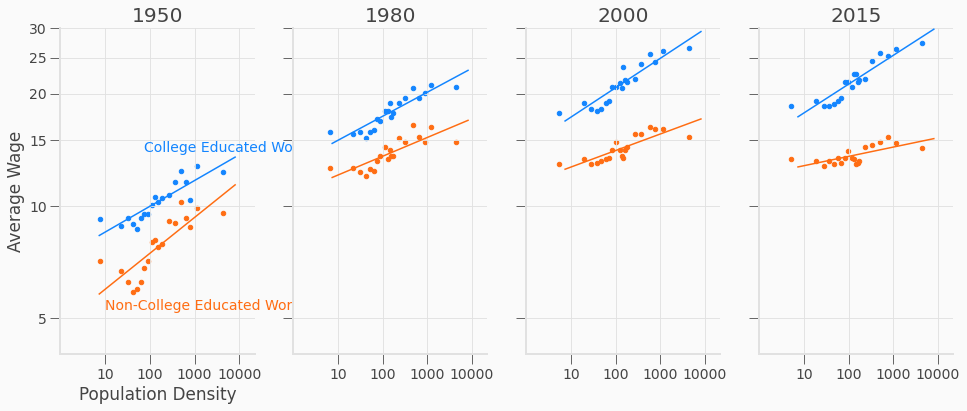

In [8]:
from sklearn.linear_model import LinearRegression

# Read in data
df = pd.read_csv("https://datascience.quantecon.org/assets/data/density_wage_data.csv")
df["year"] = df.year.astype(int)  # Convert year to int


def single_scatter_plot(df, year, educ, ax, color):
    """
    This function creates a single year's and education level's
    log density to log wage plot
    """
    # Filter data to keep only the data of interest
    _df = df.query("(year == @year) & (group == @educ)")
    _df.plot(
        kind="scatter", x="density_log", y="wages_logs", ax=ax, color=color
    )

    lr = LinearRegression()
    X = _df["density_log"].values.reshape(-1, 1)
    y = _df["wages_logs"].values.reshape(-1, 1)
    lr.fit(X, y)

    x = np.linspace(2.0, 9.0).reshape(-1, 1)
    y_pred = lr.predict(x)
    ax.plot(x, y_pred, color=color)

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 4, figsize=(16, 6))
colors = {"college": "#1385ff", "noncollege": "#ff6d13"}

for (i, year) in enumerate(df.year.unique()):
    single_scatter_plot(df, year, "college", ax[i], colors["college"])
    single_scatter_plot(df, year, "noncollege", ax[i], colors["noncollege"])
    ax[i].set_title(str(year))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, _ax) in enumerate(ax):
    # Label with words
    if i == 0:
        _ax.set_xlabel("Population Density")
    else:
        _ax.set_xlabel("")

    # Turn off right and top axis lines
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

    # Don't use such a white background color
    _ax.set_facecolor(bgcolor)

    # Change bounds
    _ax.set_ylim((np.log(4), np.log(30)))
    _ax.set_xlim((0, 10))

    # Change ticks
    xticks = [10, 100, 1000, 10000]
    _ax.set_xticks([np.log(xi) for xi in xticks])
    _ax.set_xticklabels([str(xi) for xi in xticks])

    yticks = list(range(5, 32, 5))
    _ax.set_yticks([np.log(yi) for yi in yticks])
    if i == 0:
        _ax.set_yticklabels([str(yi) for yi in yticks])
        _ax.set_ylabel("Average Wage")
    else:
        _ax.set_yticklabels([])
        _ax.set_ylabel("")

ax[0].annotate("College Educated Workers", (np.log(75), np.log(14.0)), color=colors["college"])
ax[0].annotate("Non-College Educated Workers", (np.log(10), np.log(5.25)), color=colors["noncollege"])

### Bar Charts

Bar charts are mostly used to display differences for a variable between groups though they can also
be used to show how a variable changes over time (which in some ways, is just showing a difference as grouped by time…).

Bar charts show the differences between these groups using the length of each bar, so that comparing the different groups is straightforward.

In the example below, we show a bar chart of how the unemployment rate differs across several cities
in the United States.

Text(0.5, 1.0, 'Unemployment Rate in US Cities')

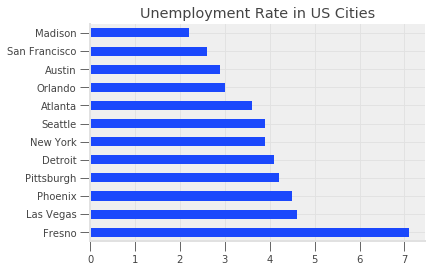

In [8]:
cities = [
    "San Francisco", "Austin", "Las Vegas", "New York", "Seattle", "Pittsburgh",
    "Detroit", "Fresno", "Phoenix", "Orlando", "Atlanta", "Madison"
]
unemp_wage = np.array([
    [2.6, 39.89], [2.9, 29.97], [4.6, 24.38], [3.9, 33.09], [3.9, 40.11], [4.2, 27.98],
    [4.1, 28.41], [7.1, 22.96], [4.5, 27.42], [3.0, 21.47], [3.6, 25.19], [2.2, 29.48]
])
df = pd.DataFrame(unemp_wage, index=cities, columns=["Unemployment", "Wage"])
df = df.sort_values(["Unemployment"], ascending=False)

fig, ax = plt.subplots()

df["Unemployment"].plot(kind="barh", ax=ax, color="#1b48fc")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Unemployment Rate in US Cities")

### Histograms

Histograms display the approximate distribution of a single variable.

They can be particularly important when your variables are not distributed normally
since we typically think of means and variances in terms of the normal distribution.

In the example below, we show a histogram of GDP growth rates over the period 1948 - 2019.

Our histogram indicates this variable is approximately normally distributed.

Text(0.5, 1.0, 'US GDP Growth from 1948-2019')

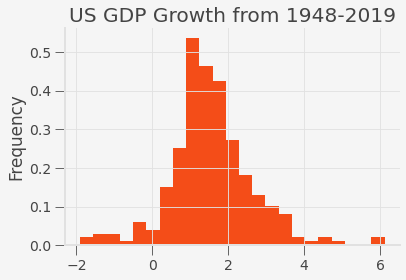

In [9]:
# GDP quarterly growth
gdp = DataReader("GDP", "fred", 1948, 2019).pct_change().dropna()
gdp = gdp * 100

fig, ax = plt.subplots()
gdp.plot(
    kind="hist", y="GDP", color=(244/255, 77/255, 24/255),
    bins=23, legend=False, density=True, ax=ax
)
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("US GDP Growth from 1948-2019")

## Color in Plots

Choosing colors for your plots is not always a straightforward task.

Visualization expert Edward Tufte <https://www.edwardtufte.com/tufte/> wrote,

> … Avoiding catastrophe becomes the first principle in bringing color to information: Above
all, do no harm ([*Envisioning Information*](https://www.edwardtufte.com/tufte/books_ei) by Edward Tufte)


So how do we “do no harm”?

### Hue Saturation Lightness

We will use the [Hue Saturation Value](https://en.wikipedia.org/wiki/HSL_and_HSV) (HSV) paradigm as a way to formalize our discussion of colors.

- **Hue**: This represents the share of each of the primary colors (red, green, blue)
  as angles around a circle. The hue begins with red at 0 degrees, green at 120
  degrees, and blue at 240 degrees (Note: matplotlib converts these back into numbers between 0 and
  1 by dividing by 360). Angles between these colors are mixes of the primary colors.  
- **Saturation**: Denotes how rich the color is using numbers between 0 and 1. At full saturation
  (saturation is 1), the color is as rich as possible. At saturation 0, the color has no
  color and is approximately a projection of the color into grayscale (Note that this is not
  exactly true).  
- **Value**: Denotes how dark the color is using numbers between 0 and 1. We view this as how much black
  has been added to a color. If a color has value 0, then it is as dark as possible (the
  color black). If the color has value 1 then it has no black and is just the original color.  


The way in which HSV covers the color space is demonstrated in the following figure.

<img src="https://datascience.quantecon.org/assets/_static/visualization_files/HSV_color_solid_cylinder_saturation_gray.png" alt="HSL_cylinder.png" style="">

  
Image attribution: By [SharkD](https://commons.wikimedia.org/w/index.php?curid=9801673).

Below, we demonstrate how colors change as we move hue/saturation/value one at a time.

In [10]:
def color_swatches(colors):

    ncolors = len(colors)
    fig, ax = plt.subplots(figsize=(ncolors*2, 2))

    for (start_x, color) in enumerate(colors):
        color_rect = patches.Rectangle((start_x, 0), 1, 1, color=color)
        ax.add_patch(color_rect)

    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    return fig

Text(0.5, 0.98, 'Varying Hue')

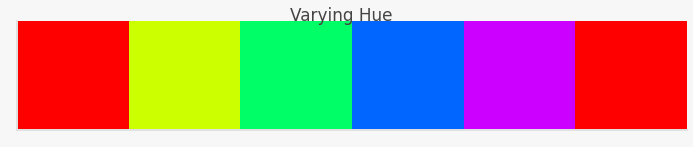

In [11]:
# Vary hue
colors = [mplc.hsv_to_rgb((i/360, 1, 1)) for i in np.linspace(0, 360, 6)]
fig = color_swatches(colors)
fig.suptitle("Varying Hue")

Text(0.5, 0.98, 'Varying Saturation')

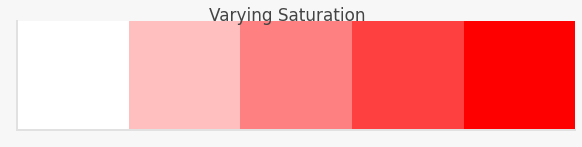

In [13]:
# Vary saturation
colors = [mplc.hsv_to_rgb((0, i, 1)) for i in np.linspace(0, 1, 5)]
fig = color_swatches(colors)
fig.suptitle("Varying Saturation")

Text(0.5, 0.98, 'Varying Value')

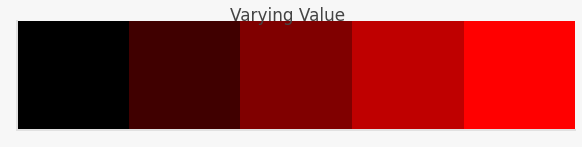

In [14]:
# Vary value
colors = [mplc.hsv_to_rgb((0, 1, i)) for i in np.linspace(0, 1, 5)]
fig = color_swatches(colors)
fig.suptitle("Varying Value")

### Color Palettes

A good color palette will exploit aspects of hue, saturation, and value to emphasize the information
in the data visualization.

For example, for qualitatively different groups (where we just want to identify separate groups
which have no quantitative relationships between them), one could fix
the saturation and value then draw $ N $ evenly spaced values from hue space.

However, creating a good color palette sometimes requires more nuance than can be attributed to
rules of thumb.

Luckily, matplotlib and other Python packages can help us choose good color
palettes. Often, relying on these pre-built color palettes and
themes is better than than creating your own.

We can get a list of all of the color palettes (referred to as colormaps by matplotlib) included
with matplotlib by doing:

In [14]:
print(plt.colormaps())

['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',

The [matplotlib documentation](https://matplotlib.org/tutorials/colors/colormaps.html)
differentiates between colormaps used for varying purposes.

Colormaps are often split into several categories based on their function (see, e.g., [Moreland]):

- Sequential: incrementally change lightness and often saturation of color,
  generally using a single hue; should be used for representing information that has ordering.  
- Diverging: change lightness and possibly saturation of two different
  colors that meet in the middle at an unsaturated color; should be used when the
  information being plotted has a critical middle value, such as topography or
  when the data deviates around zero.  
- Cyclic: change lightness of two different colors that meet in
  the middle and beginning/end at an unsaturated color; should be used for
  values that wrap around at the endpoints, such as phase angle, wind direction, or time of day.  
- Qualitative: often are miscellaneous colors; should be used to represent
  information which does not have ordering or relationships.  


Most of the examples we have used so far can use qualitative colormaps because they are simply
meant to distinguish between different variables/observations and not say something about how they
differ.

Additionally, three other sources of information on colors and color palettes are:

- The [seaborn documentation](https://seaborn.pydata.org/tutorial/color_palettes.html).  
- A [talk](https://www.youtube.com/watch?v=xAoljeRJ3lU) given at the Scipy conference in 2015 by
  Nathaniel Smith.  
- A [website](https://colorusage.arc.nasa.gov/graphics_page_design.php) literally put together by
  “rocket scientists” at NASA.  

### Do No Harm

Now that we have a little background that we can use as a common language, we can proceed with
discussing how we can use color effectively.

#### Sometimes Value is More Effective than Hue

Sometimes, in a graph with many lines, using the same color with different values is a more effective way to highlight differences than using different colors.

Compare the following example, which is a modification of an example by Larry Arend, Alex Logan, and
Galina Havin’s [graphics website](https://colorusage.arc.nasa.gov/graphics_page_design.php) (the NASA one we linked above).

In [15]:
def confusing_plot(colors):

    c1, c2, c3 = colors

    fig, ax = plt.subplots()

    x1 = np.linspace(0.2, 0.9, 5)
    x2 = np.linspace(0.3, 0.8, 5)

    ax.text(0.4, 0.10, "Not Important", color=c3, fontsize=15)
    ax.text(0.25, 0.25, "Not Important", color=c3, fontsize=15)
    ax.text(0.5, 0.70, "Not Important", color=c3, fontsize=15)
    ax.plot(x1, 1.25*x1 - 0.2, color=c3, linewidth=2)
    ax.plot(x1, 1.25*x1 + 0.1, color=c3, linewidth=2)
    ax.plot(x1, 0*x1 + 0.3, color=c3, linewidth=2)
    ax.plot(x2, 0.15*x1 + 0.4, color=c2, linewidth=3)
    ax.plot(x1, -x1 + 1.2, color=c2, linewidth=3)
    ax.plot(x1, -x1 + 1.25, color=c2, linewidth=3)
    ax.text(0.10, 0.5, "Second order", color=c2, fontsize=22)
    ax.text(0.5, 0.35, "Second order", color=c2, fontsize=22)
    ax.text(0.40, 0.65, "Second order", color=c2, fontsize=22)
    ax.plot(x2, 0.25*x1 + 0.1, color=c1, linewidth=5)
    ax.text(0.05, 0.4, "Important", color=c1, fontsize=34)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    return fig

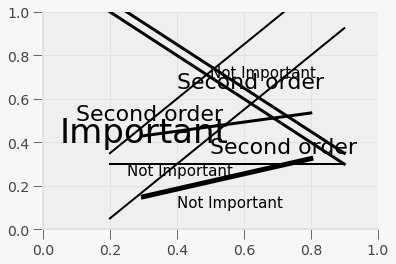

In [16]:
# All black
colors = [mplc.hsv_to_rgb((0, 1, x)) for x in [0.0, 0.0, 0.0]]
fig = confusing_plot(colors)

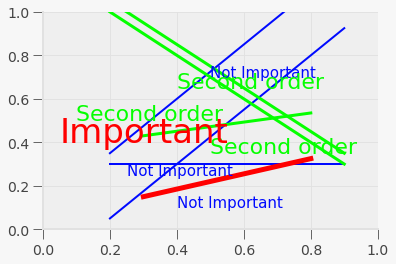

In [17]:
# Vary the hues
colors = [mplc.hsv_to_rgb((x, 1, 1)) for x in [0.0, 0.33, 0.66]]
fig = confusing_plot(colors)

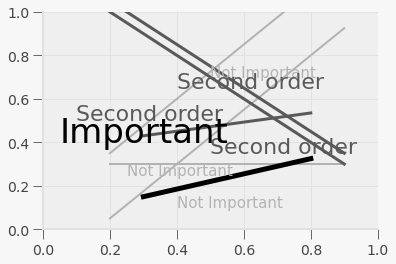

In [18]:
# Vary the values
colors = [mplc.hsv_to_rgb((0, 0, x)) for x in [0.00, 0.35, 0.7]]
fig = confusing_plot(colors)

In our opinion, the last one with no color is actually the most readable.

The point of this exercise is **not** to not use color in your plots, but rather to
encourage you to think about whether hue or value will be more effective in
communicating your message.

#### Carelessness with Value Can Make Grayscale Impossible to Read

Recall that driving the saturation to 0 is approximately equivalent to projecting the colors
onto grayscale.

Well, if you aren’t careful in choosing your colors, then they may have the same projected
values and become unidentifiable once converted to grayscale.

This code is based on an [example](https://matplotlib.org/gallery/statistics/barchart_demo.html#barchart-demo)
from the matplotlib documentation.

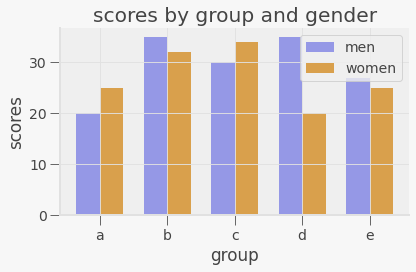

In [19]:
n_groups = 5

means_men = (20, 35, 30, 35, 27)
means_women = (25, 32, 34, 20, 25)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

color_men = mplc.hsv_to_rgb((0.66, 0.35, 0.9))
rects1 = ax.bar(
    index, means_men, bar_width, color=color_men, label='men'
)

color_women = mplc.hsv_to_rgb((0.10, 0.65, 0.85))
rects2 = ax.bar(
    index + bar_width, means_women, bar_width, color=color_women, label='women'
)

ax.set_xlabel('group')
ax.set_ylabel('scores')
ax.set_title('scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('a', 'b', 'c', 'd', 'e'))
ax.legend()

fig.tight_layout()

And here is the same image converted to grayscale.

<img src="https://datascience.quantecon.org/assets/_static/visualization_files/bar_grayscale.png" alt="bar_grayscale.png" style="">

  
The image below, from [this flowingdata blog entry](https://flowingdata.com/2012/11/09/incredibly-divided-nation-in-a-map),
shows what happens when you don’t check your colors… Don’t do this.

<img src="https://datascience.quantecon.org/assets/_static/visualization_files/Divided-nation.jpg" alt="Divided-nation.jpg" style="">

  
Warm colors (colors like red, yellow, and orange) often appear lighter than cool colors (colors
like blue, green and purple) when converted to grayscale even when they have similar values.
Sometimes to know whether colors are different enough, you just have to test it out.

#### Use Color to Draw Attention

If you are displaying information about various groups but are really only interested in how one
group differs from the others, then you should choose several close-together hues to represent the less
important groups and a distinct color to display the group of interest.

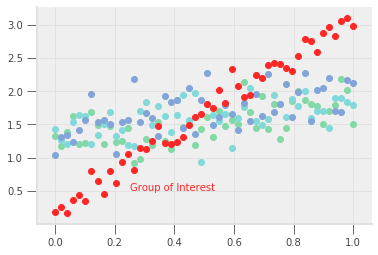

In [20]:
fig, ax = plt.subplots()

npts = 50
x = np.linspace(0, 1, npts)

np.random.seed(42)  # Set seed for reproducibility
y1 = 1.20 + 0.75*x + 0.25*np.random.randn(npts)
y2 = 1.35 + 0.50*x + 0.25*np.random.randn(npts)
y3 = 1.40 + 0.65*x + 0.25*np.random.randn(npts)
y4 = 0.15 + 3.0*x + 0.15*np.random.randn(npts)  # Group of interest

colors = [mplc.hsv_to_rgb((x, 0.4, 0.85)) for x in [0.40, 0.50, 0.60]]
colors.append(mplc.hsv_to_rgb((0.0, 0.85, 1.0)))

for (y, c) in zip([y1, y2, y3, y4], colors):
    ax.scatter(x=x, y=y, color=c, s=36)

ax.text(0.25, 0.5, "Group of Interest", color=colors[-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


<a id='exercise-1'></a>
> See exercise 2 in the [*exercise list*](#exerciselist-0)

#### Don’t Use Color to Differentiate Small Objects

Color is a great differentiator when there is enough of the colored object to see… However, when the objects
become too small, differentiating between colors, no matter how distinct, becomes quite difficult.

Below is the same plot as we had above, but we have made the scatter plot’s points smaller.

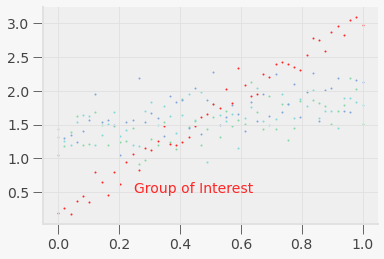

In [20]:
fig, ax = plt.subplots()

npts = 50
x = np.linspace(0, 1, npts)

np.random.seed(42)  # Set seed for reproducibility
y1 = 1.20 + 0.75*x + 0.25*np.random.randn(npts)
y2 = 1.35 + 0.50*x + 0.25*np.random.randn(npts)
y3 = 1.40 + 0.65*x + 0.25*np.random.randn(npts)
y4 = 0.15 + 3.0*x + 0.15*np.random.randn(npts)  # Group of interest

colors = [mplc.hsv_to_rgb((x, 0.4, 0.85)) for x in [0.40, 0.50, 0.60]]
colors.append(mplc.hsv_to_rgb((0.0, 0.85, 1.0)))

for (y, c) in zip([y1, y2, y3, y4], colors):
    ax.scatter(x=x, y=y, color=c, s=1)

ax.text(0.25, 0.5, "Group of Interest", color=colors[-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

It becomes harder to read, but because the red is so much darker than some of the other colors,
finding the group of interest is still possible (a lesson to be learned here!).

#### Colors’ Connotations

Some colors have connotations.

Using colors to mean the opposite of what they’re usually used for can be confusing.

For example, using red to denote positive profits and black to denote negative profits would be
a poor color choice because red is often associated with losses and black is associated with profits.

In [21]:
df = pd.DataFrame(
    {"profits": [1.5, 2.5, 3.5, -6.7, -2.0, 1.0]},
    index=[2005, 2006, 2007, 2008, 2009, 2010]
)

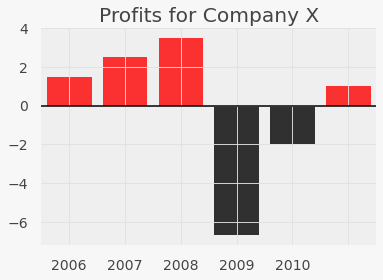

In [22]:
fig, ax = plt.subplots()

colors = ["k" if x < 0 else "r" for x in df["profits"].values]
bars = ax.bar(np.arange(len(colors)), df["profits"].values, color=colors, alpha=0.8)
ax.hlines(0, -1.0, 6.0)
ax.set_xticklabels(df.index)

ax.set_xlim(-0.5, 5.5)
ax.set_title("Profits for Company X")

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for _spine in ["right", "top", "left", "bottom"]:
    ax.spines[_spine].set_visible(False)

This plot becomes much more intuitive by using red for negative values.

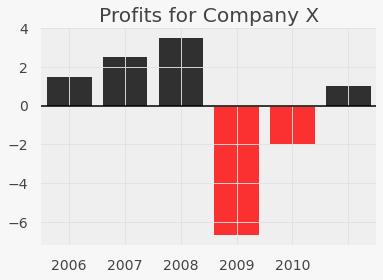

In [23]:
fig, ax = plt.subplots()

colors = ["r" if x < 0 else "k" for x in df["profits"].values]
bars = ax.bar(np.arange(len(colors)), df["profits"].values, color=colors, alpha=0.8)
ax.hlines(0, -1.0, 6.0)
ax.set_xticklabels(df.index)

ax.set_xlim(-0.5, 5.5)
ax.set_title("Profits for Company X")

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for _spine in ["right", "top", "left", "bottom"]:
    ax.spines[_spine].set_visible(False)

#### Accounting for Color Blindness

Nearly 1 in 10 men have some form of color blindness.

The most prevalent form makes differentiating between red
and green difficult.

So, besides making your plots feel “Christmas-themed”, using both red and green to illustrate differences in a plot can often make your visualization difficult for some to follow.

Some Python libraries allow you to simulate different forms of color blindness or choose
sensible defaults for colors.

We recommend viewing the documentation for
[colorspacious](https://colorspacious.readthedocs.io/en/latest/tutorial.html#simulating-colorblindness)
and [viscm](https://github.com/matplotlib/viscm).

## Visualization Rules

We have already discussed some guidelines for color.

We will now discuss some guidelines for which elements to include and how to structure your graphs.

Violating each of these may make sense in particular situations, but please have a
good reason (and one you can explain when someone points out what you’ve done).

The main theme for these guidelines will be to keep the plot as simple as possible so that your
readers can get the clearest understanding of your story.

Many people try too hard to make their plot eye-catching, and in the process, they destroy the
message in the graph.

Graphs should be a simple as possible, but not simpler.

We will discuss some guidelines that we feel are most abused, but many very good books have
been written on this subject.

Some books that we have found extremely instructive are:

1. *Visual Display of Quantitative Information* by Edward Tufte.  
1. *The Wall Street Journal Guide to Information Graphics: The Dos and Don’ts of Presenting Data,
  Facts, and Figures* by Dona M Wong.  
1. *The Functional Art: An introduction to information graphics and visualization* by Alberto Cairo.  


Some blogs that we think are useful for seeing well-done visualizations are:

1. Flowing Data: [https://flowingdata.com/](https://flowingdata.com/)  
1. Story Telling with Data: [http://www.storytellingwithdata.com/](http://www.storytellingwithdata.com/)  
1. Visualizing Data: [http://www.visualisingdata.com/](http://www.visualisingdata.com/)  
1. Junk Charts: [https://junkcharts.typepad.com/](https://junkcharts.typepad.com/)  


As you begin to create more visualizations in your work, we recommend reading these books and blogs.

Seeing how others display their information will ensure that when you run into interesting
problems in the future, you’ll have a well of knowledge that you can call upon.

In fact, one friend of ours takes this very seriously.

He keeps an organized binder of graphics that he has seen and likes.

He reads this binder, sometimes for hours, when he is thinking about how to communicate messages
for his presentations.

A couple last links to specific articles we enjoyed:

- [This Financial Times article](https://ig.ft.com/science-of-charts) is a great exercise to
  demonstrate how choice of graph type can affect a visualizations interpretability.  
- [This article](https://towardsdatascience.com/data-visualization-best-practices-less-is-more-and-people-dont-read-ba41b8f29e7b)
  does an exceptional job at redesigning graphics that were originally poorly done.  
- [Duke library data visualization guide](https://guides.library.duke.edu/datavis/topten) has a
  few concise rules worth reviewing.  

### Bar Plot Recommendations

In Dona Wong’s book, she advises against using *zebra patterns*.

In [30]:
df = pd.DataFrame(
    {
        "Unemployment Rate": [5.20, 5.67, 9.20, 4.03, 3.80],
        "Pension Expenditure (% of GDP)": [4.18, 4.70, 13.90, 6.24, 7.06],
        "Social Welfare Expenditure (% of GDP)": [7.42, 9.84, 19.72, 12.98, 14.50],
        "Highest Tax Rate": [47, 33, 59.6, 50, 39.6]
    },
    index = ["Australia", "Canada", "France", "UK", "USA"]
)

def create_barplot(df, colors):

    fig, ax = plt.subplots(figsize=(14, 6))

    df.T.plot(kind="bar", color=colors, ax=ax, edgecolor="k", rot=0)
    ax.legend(bbox_to_anchor=(0, 1.02, 1.0, 1.02), loc=3, mode="expand", ncol=5)
    ax.set_xticklabels(df.columns, fontsize=6)

    return fig

Instead, she proposes using different shades of the same color (ordered from lightest to darkest!).

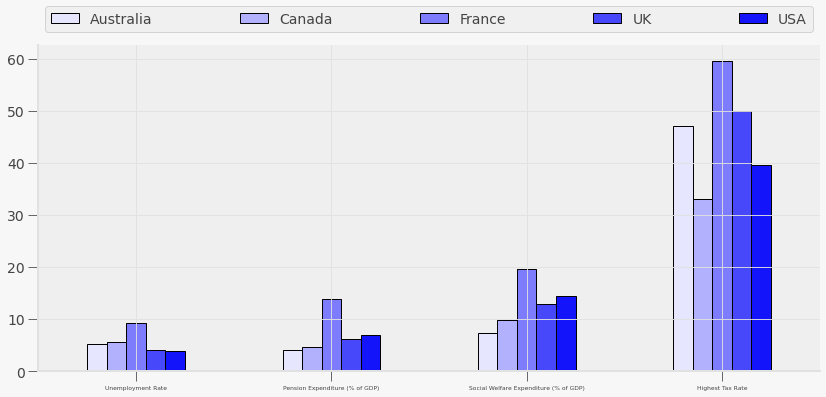

In [29]:
colors = [
    (0.902, 0.902, 0.997), (0.695, 0.695, 0.993), (0.488, 0.488, 0.989),
    (0.282, 0.282, 0.985), (0.078, 0.078, 0.980)
]

create_barplot(df, colors);

Notice that we put a legend at the top and maintain the same order as kept in the bars.

Additionally, the general consensus is that starting bar plots at any number besides 0 is a
misrepresentation of the data.

Always start your bar plots at 0!

An example of how starting at a non-zero number is misleading can be seen below and was originally from the
[flowingdata blog](https://flowingdata.com/2012/08/06/fox-news-continues-charting-excellence).

First, we look at a reproduction of the originally displayed image.

Text(0.5, 1.0, 'IF BUSH TAX CUTS EXPIRE\nTop Tax Rate')

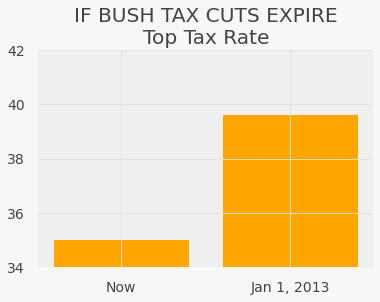

In [31]:
fig, ax = plt.subplots()

ax.bar([0, 1], [35, 39.6], color="orange")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Now", "Jan 1, 2013"])
ax.set_ylim(34, 42)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for _spine in ["right", "top", "left", "bottom"]:
    ax.spines[_spine].set_visible(False)

ax.set_title("IF BUSH TAX CUTS EXPIRE\nTop Tax Rate")

This looks like a big difference!

In fact, your eyes are telling you that taxes will increase by a factor of 5 if the tax cuts expire.

If we start this same bar plot at 0, the chart becomes much less striking and tells you that the percentage
increase in the top tax rate is only 5-10 percent.

Text(0.5, 1.0, 'IF BUSH TAX CUTS EXPIRE\nTop Tax Rate')

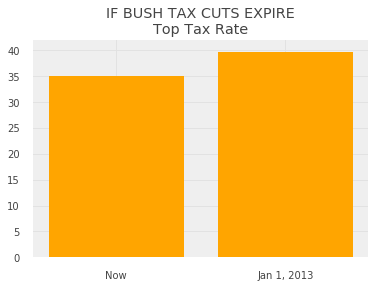

In [28]:
fig, ax = plt.subplots()

ax.bar([0, 1], [35, 39.6], color="orange")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Now", "Jan 1, 2013"])
ax.set_ylim(0, 42)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for _spine in ["right", "top", "left", "bottom"]:
    ax.spines[_spine].set_visible(False)

ax.set_title("IF BUSH TAX CUTS EXPIRE\nTop Tax Rate")

We also have opinions about what type of person uses all caps, but we’ll keep that to ourselves for
now.

### Pie Plots

As a general rule, you should avoid pie plots.

When comparing groups, your reader can more easily measure the heights on a
bar graph than determine the size of the angles in a pie chart.

Let’s look at an example of this below.

Text(0.5, 0.98, 'How many pieces of pie eaten')

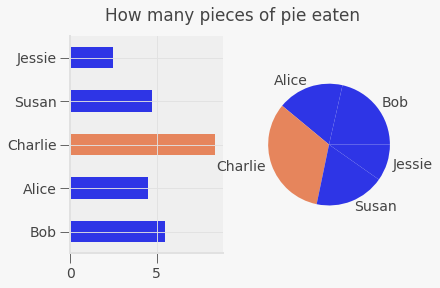

In [32]:
df = pd.DataFrame(
    {"values": [5.5, 4.5, 8.4, 4.75, 2.5]},
    index=["Bob", "Alice", "Charlie", "Susan", "Jessie"]
)

colors = [mplc.hsv_to_rgb((0.66, 0.8, 0.9))]*2
colors += [mplc.hsv_to_rgb((0.05, 0.6, 0.9))]
colors += [mplc.hsv_to_rgb((0.66, 0.8, 0.9))]*2

fig, ax = plt.subplots(1, 2)

df.plot(kind="barh", y="values", ax=ax[0], legend=False, color=colors)
df.plot(kind="pie", y="values", ax=ax[1], legend=False, colors=colors, startangle=0)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].set_ylabel("")
fig.suptitle("How many pieces of pie eaten")

Using the pie chart, can you tell who ate more pie Alice or Susan? How about with the bar chart?

The pie chart can sometimes be used to illustrate whether one or two groups is much larger than the
others.

If you were making a case that Charlie ate too much of the pie and should pay more than an equal split,
then a pie chart works (though a bar plot also works…).

If you wanted to make a more precise point, then you might consider going with a bar plot instead.

### Simplify Line Plots

We’ve tried to emphasize repeatedly that simplifying your visualizations is essential to being able
to communicate your message.

We do it again here and will do it a few more times after this…

Don’t try and fit too much information into a single line plot.

We see people do this very frequently – remember that a visualization should have ONE main message.

Do not pollute your message with extra information.

In our example using World Bank data below, we will show that Japan’s population is aging faster
than that of many other economically successful countries.

We show this using the age dependency ratio, which is the number of individuals aged 65+ divided by the number of individuals who are 15-64, for each country over time.

A high age dependency ratio means that the government will have a smaller tax base to collect from
but have relatively higher health and pension expenditures to pay to the old.

In [33]:
download_url = "https://datascience.quantecon.org/assets/data/WorldBank_AgeDependencyRatio.csv"
df = pd.read_csv(download_url, na_values="..")
df = df[["Country Name", "1960", "1970", "1980", "1990", "2000", "2010", "2017"]]
df = df.set_index("Country Name").T
df.index = df.index.values.astype(int)

Let’s visualize these variables for a collection of many developed countries.

Text(0, 0.5, 'Age Dependency Ratio')

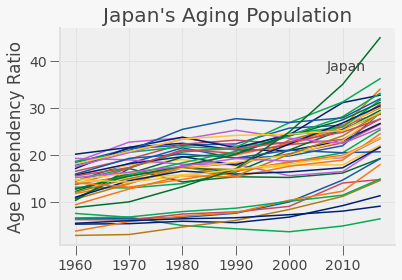

In [34]:
fig, ax = plt.subplots()

df.plot(ax=ax, legend=False)
ax.text(2007, 38, "Japan")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Japan's Aging Population")
ax.set_ylabel("Age Dependency Ratio")

Notice that with so many lines, the message about Japan is hidden or polluted by noise.

If we did want to demonstrate that Japan is significantly different than many other developed countries,
we might try a plot like this:

Text(0, 0.5, 'Age Dependency Ratio')

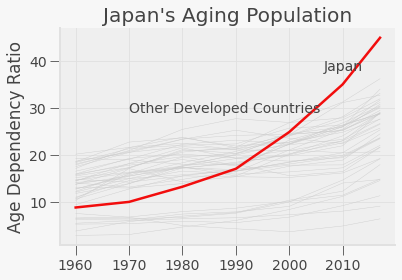

In [35]:
fig, ax = plt.subplots()

not_japan = list(df.columns)
not_japan.remove("Japan")

df[not_japan].plot(ax=ax, color=[(0.8, 0.8, 0.8)], lw=0.4, legend=False)
ax.text(1970, 29, "Other Developed Countries")

df["Japan"].plot(ax=ax, color=(0.95, 0.05, 0.05), lw=2.5, legend=False)
ax.text(2006.5, 38, "Japan")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Japan's Aging Population")
ax.set_ylabel("Age Dependency Ratio")

However, placing this many lines on a single plot is definitely an exception, and we encourage you
to do so sparingly.

Generally, you should only have a few informative lines for each plot.

We now will focus our graph on a few countries of interest.

To do so, the plot below uses many different line styles.

Text(0, 0.5, 'Age Dependency Ratio')

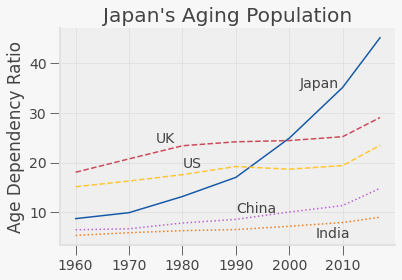

In [36]:
fig, ax = plt.subplots()

df["Japan"].plot(ax=ax, legend=False, linestyle="solid")
ax.text(2002, 35, "Japan")
df["United Kingdom"].plot(ax=ax, legend=False, linestyle="dashed")
ax.text(1975, 24, "UK")
df["United States"].plot(ax=ax, legend=False, linestyle="dashed")
ax.text(1980, 19, "US")
df["China"].plot(ax=ax, legend=False, linestyle="dotted")
ax.text(1990, 10, "China")
df["India"].plot(ax=ax, legend=False, linestyle="dotted")
ax.text(2005, 5, "India")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Japan's Aging Population")
ax.set_ylabel("Age Dependency Ratio")

There are some good-use cases for using line styles to distinguish between different pieces
of data, but not many.

In particular, having this many different styles and colors makes it difficult to figure out what is going on.

Instead, we recommend using color and line width instead of line styles to highlight certain pieces of
information, as seen below.

Text(0, 0.5, 'Age Dependency Ratio')

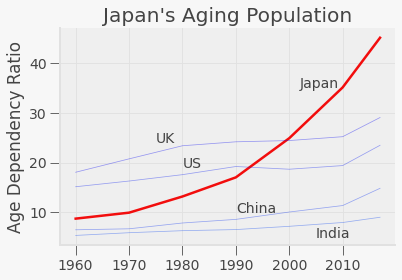

In [37]:
fig, ax = plt.subplots()

emph_color = (0.95, 0.05, 0.05)
sec_color = [(0.05, 0.05+0.075*x, 0.95) for x in range(4)]
df["Japan"].plot(ax=ax, legend=False, color=emph_color, linewidth=2.5)
ax.text(2002, 35, "Japan")
df["United Kingdom"].plot(ax=ax, legend=False, color=sec_color[0], alpha=0.4, linewidth=0.75)
ax.text(1975, 24, "UK")
df["United States"].plot(ax=ax, legend=False, color=sec_color[1], alpha=0.4, linewidth=0.75)
ax.text(1980, 19, "US")
df["China"].plot(ax=ax, legend=False, color=sec_color[2], alpha=0.4, linewidth=0.75)
ax.text(1990, 10, "China")
df["India"].plot(ax=ax, legend=False, color=sec_color[3], alpha=0.4, linewidth=0.75)
ax.text(2005, 5, "India")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Japan's Aging Population")
ax.set_ylabel("Age Dependency Ratio")

### Tick Steps

Use easy to interpret increments such as multiples of 2, 5, 10, 25 etc…

Using increments like `0, 3, 6, 9, 12, ...` make it more difficult for your reader to do mentally
determine what the values between the lines are:

[Text(0, 0, '0'),
 Text(0, 0, '5'),
 Text(0, 0, '10'),
 Text(0, 0, '15'),
 Text(0, 0, '20'),
 Text(0, 0, '25')]

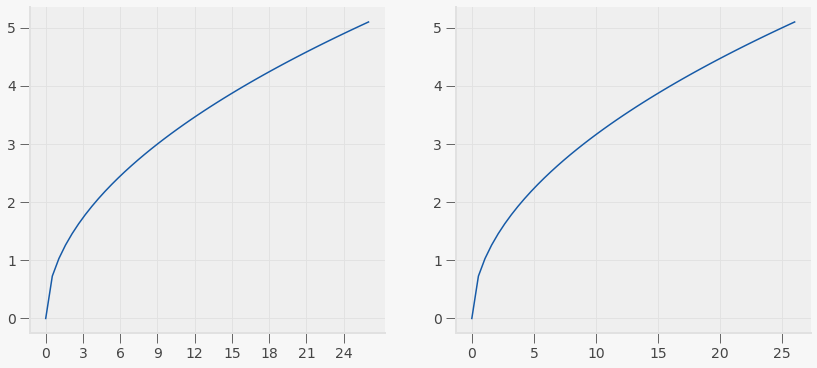

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

x = np.linspace(0, 26, 50)

ax[0].plot(x, np.sqrt(x))
ax[1].plot(x, np.sqrt(x))

ax[0].set_xticks(np.arange(0, 27, 3))
ax[0].set_xticklabels(np.arange(0, 27, 3))
ax[1].set_xticks(np.arange(0, 27, 5))
ax[1].set_xticklabels(np.arange(0, 27, 5))

### No Background Colors

There are no reasons to use background colors in your visualizations.

Research has shown that white or very light grays provide the best contrast as a background.

Compare the following graphs and think about which feels better.

Text(0.5, 1.0, 'IF BUSH TAX CUTS EXPIRE\nTop Tax Rate')

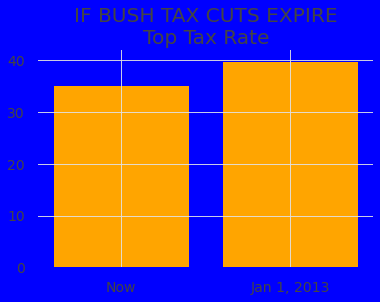

In [39]:
fig, ax = plt.subplots()

ax.bar([0, 1], [35, 39.6], color="orange")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Now", "Jan 1, 2013"])
ax.set_ylim(0, 42)

bgcolor = "blue"
fig.set_facecolor(bgcolor)
ax.set_facecolor(bgcolor)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for _spine in ["right", "top", "left", "bottom"]:
    ax.spines[_spine].set_visible(False)

ax.set_title("IF BUSH TAX CUTS EXPIRE\nTop Tax Rate")

versus

Text(0.5, 1.0, 'IF BUSH TAX CUTS EXPIRE\nTop Tax Rate')

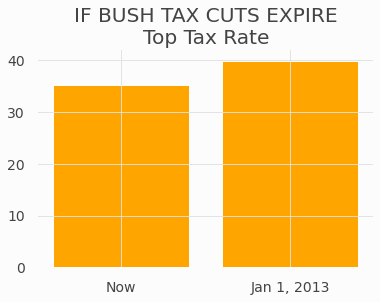

In [40]:
fig, ax = plt.subplots()

ax.bar([0, 1], [35, 39.6], color="orange")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Now", "Jan 1, 2013"])
ax.set_ylim(0, 42)

bgcolor = (0.99, 0.99, 0.99)
fig.set_facecolor(bgcolor)
ax.set_facecolor(bgcolor)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for _spine in ["right", "top", "left", "bottom"]:
    ax.spines[_spine].set_visible(False)

ax.set_title("IF BUSH TAX CUTS EXPIRE\nTop Tax Rate")

### Legends

Legends are quite common in charts, but many visualization experts advise against using them.

Legends have several weaknesses:

1. Relying solely on line color often makes a black and white version of your plot effectively
  useless, since you don’t know whether the colors will be distinguishable in grayscale.  
1. Legends require people to distinguish between small samples of colors. For
  someone with weak eyesight or color blindness, this can make interpreting graphs nearly
  impossible.  
1. They add distance between the data and its description. This requires peoples’ eyes to go back
  and forth between the lines and the legend when trying to understand the story being told. This
  distracts from the ability to digest the story quickly and succinctly.  


To demonstrate this, we revisit our age dependency ratio example from earlier.

In [41]:
download_url = "https://datascience.quantecon.org/assets/data/WorldBank_AgeDependencyRatio.csv"
df = pd.read_csv(download_url, na_values="..")
df = df[["Country Name", "1960", "1970", "1980", "1990", "2000", "2010", "2017"]]
df = df.set_index("Country Name").T
df.index = df.index.values.astype(int)

With a legend:

Text(0, 0.5, 'Age Dependency Ratio')

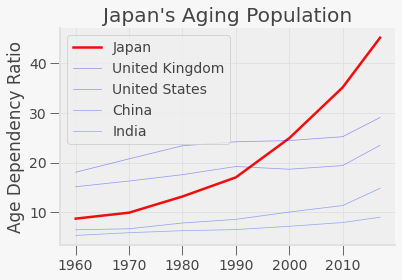

In [42]:
fig, ax = plt.subplots()

emph_color = (0.95, 0.05, 0.05)
sec_color = [(0.05, 0.05+0.075*x, 0.95) for x in range(4)]
df["Japan"].plot(ax=ax, legend=True, color=emph_color, linewidth=2.5)
df["United Kingdom"].plot(ax=ax, legend=True, color=sec_color[0], alpha=0.4, linewidth=0.75)
df["United States"].plot(ax=ax, legend=True, color=sec_color[1], alpha=0.4, linewidth=0.75)
df["China"].plot(ax=ax, legend=True, color=sec_color[2], alpha=0.4, linewidth=0.75)
df["India"].plot(ax=ax, legend=True, color=sec_color[3], alpha=0.4, linewidth=0.75)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Japan's Aging Population")
ax.set_ylabel("Age Dependency Ratio")

With labels:

Text(0, 0.5, 'Age Dependency Ratio')

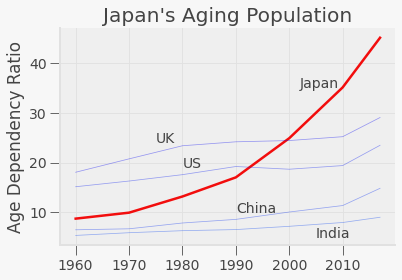

In [43]:
fig, ax = plt.subplots()

emph_color = (0.95, 0.05, 0.05)
sec_color = [(0.05, 0.05+0.075*x, 0.95) for x in range(4)]
df["Japan"].plot(ax=ax, legend=False, color=emph_color, linewidth=2.5)
ax.text(2002, 35, "Japan")
df["United Kingdom"].plot(ax=ax, legend=False, color=sec_color[0], alpha=0.4, linewidth=0.75)
ax.text(1975, 24, "UK")
df["United States"].plot(ax=ax, legend=False, color=sec_color[1], alpha=0.4, linewidth=0.75)
ax.text(1980, 19, "US")
df["China"].plot(ax=ax, legend=False, color=sec_color[2], alpha=0.4, linewidth=0.75)
ax.text(1990, 10, "China")
df["India"].plot(ax=ax, legend=False, color=sec_color[3], alpha=0.4, linewidth=0.75)
ax.text(2005, 5, "India")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Japan's Aging Population")
ax.set_ylabel("Age Dependency Ratio")

Most people find the example with labels to be a more readable graph.

### Limit the Information in a Single Plot

Don’t try to put too much information in a single plot!

We have tried to emphasize this point throughout this lecture, but it is so important that
we are emphasizing it again!

Don’t information overload your audience!

### Talk to Other People

Our last guideline: talk with others about your visualization.

The best way to determine whether other people understand your message is to show it to them.

## References

<a id='ely'></a>
**[1]** In particular, it is based on [this lecture](https://www.aeaweb.org/webcasts/2019/aea-ely-lecture-work-of-the-past-work-of-the-future)
by Autor presented at the annual AEA meeting in January, 2019. This
is a prestigious invited lecture with a large audience, so it is a more
“polished” than the typical academic lecture. It is worth
watching. Notice how almost every slide includes data
visualizations, and very few consist solely of text. Also, notice
the ways that the NYT modified Autor’s figures and think about
whether these changes improved the figures.

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

Create a draft of the alternative way to organize time and education -- that is, have two subplots (one for each education level) and four groups of points (one for each year).

Why do you think they chose to organize the information as they did rather than this way?

([*back to text*](#exercise-0))

**Exercise 2**

Using the data on Canadian GDP growth below, create a bar chart which uses one color for the
bars for the years 2000 to 2008, a red for 2009, and the same color as before for 2010 to 2018.

Text(0.5, 1.0, 'Canadian GDP Growth')

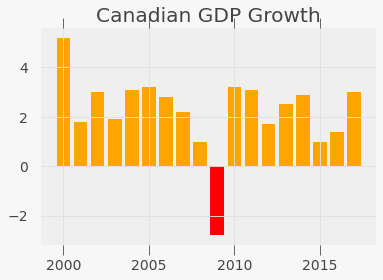

In [91]:
ca_gdp = pd.Series(
    [5.2, 1.8, 3.0, 1.9, 3.1, 3.2, 2.8, 2.2, 1.0, -2.8, 3.2, 3.1, 1.7, 2.5, 2.9, 1.0, 1.4, 3.0],
    index=list(range(2000, 2018))
)

fig, ax = plt.subplots()
color = ['orange' for i in ca_gdp.index]
for i, year  in enumerate(ca_gdp.index):
    if year == 2009:
        color[i] = 'red' 
        
ax.bar(ca_gdp.index, ca_gdp,color = color)

ax.set_xticks(range(2000,2018,5))
ax.set_xticklabels(range(2000,2018,5))

ax.xaxis.set_ticks_position('default')
ax.yaxis.set_ticks_position('none')



for side in ["right", "top", "left", "bottom"]:
    ax.spines[side].set_visible(False)
ax.set_title("Canadian GDP Growth")

([*back to text*](#exercise-1))